# Comparing Total Gas Masses Between Analyses - XXL-100-GC

This notebook measures gas masses for the XXL-100-GC sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xxlgc100_colour, xxl_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

In [2]:
xxlgc100 = pd.read_csv("../../sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   0%|                                                      | 0/99 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-94 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   1%|▍                                             | 1/99 [00:05<09:47,  5.99s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-96 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   2%|▉                                             | 2/99 [00:13<11:08,  6.90s/it]/mnt/pact/dt23

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-25 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  34%|███████████████▍                             | 34/99 [04:16<17:16, 15.95s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-41 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  35%|███████████████▉                             | 35/99 [04:41<20:06, 18.85s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-50 has not been detected in all regi

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-104 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  47%|█████████████████████▎                       | 47/99 [06:50<07:51,  9.06s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-88 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  48%|█████████████████████▊                       | 48/99 [06:58<07:19,  8.62s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-87 has not been detected in all reg

Setting up Galaxy Clusters:  64%|████████████████████████████▋                | 63/99 [07:51<01:14,  2.08s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-534 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  65%|█████████████████████████████                | 64/99 [07:53<01:17,  2.21s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-517 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  66%|█████████████████████████████▌               | 65/99 [07:55<01:16,  2.25s/it]/mnt/pact/dt

Setting up Galaxy Clusters:  80%|███████████████████████████████████▉         | 79/99 [08:38<00:49,  2.46s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-512 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  81%|████████████████████████████████████▎        | 80/99 [08:41<00:49,  2.61s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-520 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  82%|████████████████████████████████████▊        | 81/99 [08:43<00:42,  2.35s/it]/mnt/pact/dt

In [4]:
del xxl_srcs['XLSSC-11']

## Running PSF Correction

In [5]:
rl_psf(xxl_srcs)

Generating products of type(s) image: 100%|███████████████████████████████████| 96/96 [00:12<00:00,  7.85it/s]


## Reading in literature data

### Gas masses from literature

In [48]:
xxl_lit_gms = [xxlgc100[xxlgc100['name'] == n].iloc[0][['mg500', 'mg500_err']].values*1e+13 
               for n in xxl_srcs.names]
xxl_lit_gms = Quantity(xxl_lit_gms, 'Msun')

### Conversion Temperatures

In [7]:
xxl_conv_txs = []

for src in xxl_srcs:
    xxl_conv_txs.append(xxlgc100[xxlgc100['name'] == src.name].iloc[0]['T300kpc'])
    
xxl_conv_txs = Quantity(xxl_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to 1.3$R_{500}$

In [8]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [9]:
xxl_beta_13_dp = inv_abel_fitted_model(xxl_srcs, 'beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))

Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 96/96 [00:24<00:00,  3.92it/s]
Fitting data, inverse Abel transforming, and measuring densities:  15%|█      | 14/96 [04:49<28:44, 21.03s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  32%|██▎    | 31/96 [11:01<23:54, 22.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 592.57355368  839.45523383 1400.11765769]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 43/96 [15:32<18:52, 21.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 164.46725325  876.31888536 1384.46305875]


Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 59/96 [21:19<13:24, 21.74s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  69%|████▊  | 66/96 [23:40<10:17, 20.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [692.21433358 746.73046772 516.32575274]


Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 86/96 [30:49<03:26, 20.67s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-548's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 96/96 [34:19<00:00, 21.46s/it]


In [10]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [11]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)


Fitting density model to XXL profiles:  33%|███████████▎                      | 32/96 [16:17<35:30, 33.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 746.42009821 3185.94649684 3130.76430742]


Fitting density model to XXL profiles:  83%|████████████████████████████▎     | 80/96 [41:19<08:25, 31.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 321.36265682 1157.74232555  922.84946051]


Fitting density model to XXL profiles: 100%|██████████████████████████████████| 96/96 [49:11<00:00, 30.75s/it]


In [56]:
xxl_beta_king_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", xxl_srcs[dp.src_name].r500)[0]
            xxl_beta_king_13_gm.append(gm)
        else:
            xxl_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)
        
xxl_beta_king_13_gm = Quantity(xxl_beta_king_13_gm, 'Msun')

Calculating XXL gas masses: 100%|█████████████████████████████████████████████| 96/96 [00:05<00:00, 17.27it/s]


In [13]:
print("{s} out of {t} gas mass measurements produced a "\
      "result".format(s=np.isfinite(xxl_beta_king_13_gm[:, 0]).sum(), t=len(xxl_beta_king_13_gm)))

93 out of 96 gas mass measurements produced a result


This section deals with two data problems, one with the literature XXL values (where an XXL gas mass is smaller than its uncertainty - messes up the plot), and another with an XGA measurement. This measurement was very low mass, and again was messing up the plot. I have made this section print the name of the cluster with this problem, but it is also removed from the gas mass array to improve the look of the figure.

In [64]:
if np.any((xxl_lit_gms[:, 0] - xxl_lit_gms[:, 1]) < 0):
    xxl_lit_gms[np.argmin((xxl_lit_gms[:, 0] - xxl_lit_gms[:, 1]))] = Quantity([np.NaN, np.NaN], 'Msun')

if len(xxl_beta_king_13_gm[xxl_beta_king_13_gm < Quantity(1e+8, 'Msun')]) != 0:
    which_low = np.where(xxl_beta_king_13_gm[:, 0] < Quantity(1e+8, 'Msun'))[0]
    print(xxl_srcs.names[which_low])
    xxl_beta_king_13_gm[which_low] = np.NaN

['XLSSC-90']


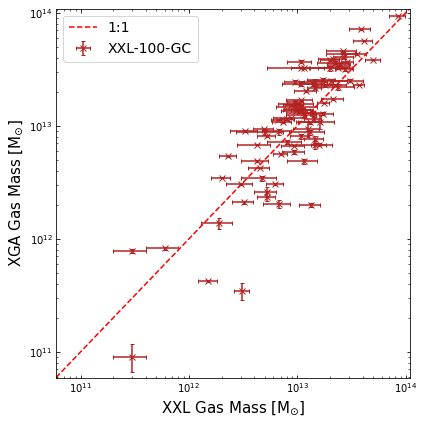

In [65]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

ax.minorticks_on()
ax.tick_params(which='both', top=True, right=True, direction='in')
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_beta_king_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=xxlgc100_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("../../outputs/figures/xxl_beta_king_1.3r500_gm_comp.pdf")
plt.show()
plt.close('all')

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [15]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [16]:
xxl_dblbeta_13_dp = inv_abel_fitted_model(xxl_srcs, 'double_beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   1%|        | 1/96 [00:20<32:27, 20.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [277.3966463  482.7759422  515.38182505 333.53105937 343.58824206
 434.1663642 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-96's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 2/96 [00:42<33:14, 21.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 384.58105057  574.5983869  1188.59813565  242.01228501  453.48054669
 1036.7373896 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-102's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   3%|▎       | 3/96 [01:02<32:24, 20.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 446.86282129  470.45499804 1878.10546279  230.25983064  265.63380865
 1600.53478788]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-106's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 4/96 [01:24<32:50, 21.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 380.28437461  659.23234276 1326.71603     629.0417011   738.6545894
 1142.91777056]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-107's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 5/96 [01:45<32:00, 21.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [440.71257783 935.82058247 987.60787544 285.94886115 466.31007279
 916.31989595]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-100's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   6%|▌       | 6/96 [02:05<31:05, 20.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 570.43836248 1298.53890143 1027.48226785  475.47368212  708.37460994
  869.99752027]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-93's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 7/96 [02:27<31:08, 20.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [373.32748695 611.5298774  885.10845528 524.56657785 843.94619742
 764.44365627]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-108's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   8%|▋       | 8/96 [02:48<30:51, 21.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 498.52899328 2017.37644226 2180.45248258  260.37335264  412.64968825
 1941.52805999]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-95's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   9%|▊       | 9/96 [03:08<30:04, 20.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [464.98483467 581.97074194 674.75249547 676.00019398 559.78953731
 813.98332789]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-92's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  10%|▋      | 10/96 [03:28<29:39, 20.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 418.30819436 1306.44626112 1990.65944668  206.30901153  247.39522666
 1573.3297917 ]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▊      | 11/96 [03:49<29:16, 20.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [432.36963447 820.61361306 693.00102759 386.76840104 655.95821385
 530.32065284]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-109's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  12%|▉      | 12/96 [04:09<28:48, 20.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [306.1883876  650.12200709 658.72603111 301.57502733 512.45869755
 652.79599578]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-112's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  14%|▉      | 13/96 [04:33<29:35, 21.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 623.09222327 1863.19156437 2218.70639222  323.2397564   574.95731041
 2127.60480339]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-83's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  15%|█      | 14/96 [04:54<29:11, 21.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [314.97839728 907.89215177 834.74864923 380.68557844 717.58159924
 727.59407957]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  16%|█      | 15/96 [05:14<28:29, 21.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 352.0341611   495.25819185 2177.75920252  452.54283806  451.58571057
 1066.9485935 ]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▏     | 16/96 [05:36<28:14, 21.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 227.78912166  767.98712197 1142.34530022  261.79068652  456.07985247
 1018.59685581]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▏     | 17/96 [05:59<28:50, 21.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 432.11520307  934.40745953 1929.36342115 1441.75796035 1002.55975699
 1254.08157824]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▎     | 18/96 [06:23<29:04, 22.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 259.18351292  256.91531465 1383.32789885 1241.28219179  819.39152845
  271.36260669]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-99's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  20%|█▍     | 19/96 [06:44<28:23, 22.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [278.47217398 379.88576356 380.42264608 404.03803709 384.78201039
 512.12431848]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-97's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  21%|█▍     | 20/96 [07:05<27:21, 21.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 688.14821797 1167.08413221 1048.84949186  660.99923736 1007.12343173
 1191.23795699]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-110's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  22%|█▌     | 21/96 [07:25<26:31, 21.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [323.27151684 704.99047742 548.69456264 298.24896223 381.75031235
 626.66687425]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 205.96490461 1089.54857276  853.25487433  202.67025619  335.69355403
  655.73761418]


Fitting data, inverse Abel transforming, and measuring densities:  23%|█▌     | 22/96 [07:52<28:17, 22.94s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-72's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 23/96 [08:13<27:19, 22.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 694.43543934 1353.39865736 2207.65862962 1025.07067225 1825.98729186
 2186.04719452]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-56's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  25%|█▊     | 24/96 [08:35<26:46, 22.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 698.49298943 1274.74315038 1963.07505879  255.52367169  322.49878717
 1884.18203906]


Fitting data, inverse Abel transforming, and measuring densities:  26%|█▊     | 25/96 [09:01<27:33, 23.28s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-23's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  27%|█▉     | 26/96 [09:21<26:07, 22.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [461.49120566 809.42804652 824.669769   570.76659219 783.55425575
 771.78599402]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 27/96 [09:44<25:58, 22.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 997.75712244 1018.18036232 2219.39774414 1569.27436186 1873.6733925
 2244.65874738]


Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 28/96 [10:06<25:16, 22.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 827.5811543  1381.19266319 1398.33331179  857.71052484 1063.59623857
 1411.03982504]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██     | 29/96 [10:28<24:47, 22.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1057.06554707 1679.0433117  1437.30088669 1509.18012766 1563.71379418
 1713.9931509 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-62's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 30/96 [10:53<25:17, 23.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [262.2811547  621.38660922 661.51064131 262.26024337 872.3795514
 963.19322344]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-1's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  32%|██▎    | 31/96 [11:15<24:37, 22.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 543.47854873  936.13394816 2185.61031451 1347.44238956 1799.37486445
 1855.50348463]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1521.35942118 1339.42493822 1476.12530056  328.73686247  325.1092931
  544.6630654 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-54's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  34%|██▍    | 33/96 [12:09<26:12, 24.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 371.12248601  379.49963166 1221.39916514  701.965616    685.69348657
  784.82370758]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 34/96 [12:37<26:34, 25.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 496.48052765  852.54126859 1394.22291293 1070.36903056 1225.1021066
 1400.40867483]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1004.31573927 1265.18270513 1280.62157447  989.98202497  975.57099305
 1412.06404634]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▌    | 35/96 [12:58<24:55, 24.51s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-55's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 36/96 [13:21<24:04, 24.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 361.2650906  1139.16872821 1656.5747518  1130.89225856 1202.88805273
 1441.19092469]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-52's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  39%|██▋    | 37/96 [13:44<23:12, 23.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 532.94404359  956.11660645 1779.22077885  725.11387553 1110.10230051
 1447.55753673]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 38/96 [14:07<22:33, 23.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 459.34877746 1543.94770661 1027.39287695 1350.12536057 1474.78425956
 1487.52660178]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-103's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  41%|██▊    | 39/96 [14:28<21:35, 22.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 393.86744645  884.22251575 1332.42296057  311.6996868   550.99846237
  836.37489944]


Fitting data, inverse Abel transforming, and measuring densities:  42%|██▉    | 40/96 [14:50<21:00, 22.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 658.8210152   810.55701094  920.86167609  833.66794378  879.87706993
 1013.17415548]


Fitting data, inverse Abel transforming, and measuring densities:  43%|██▉    | 41/96 [15:13<20:50, 22.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 877.38321892 1380.98227512 1321.13523161  816.05711104  977.58415936
 1413.10088785]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-27's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 42/96 [15:36<20:27, 22.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 781.08789688 1050.90705984 1541.87223885  261.14547697  345.55258711
 1448.15785163]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 43/96 [15:56<19:20, 21.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 646.63940671  857.33198758 1141.95816072  737.09068    1435.1842949
 1369.8063864 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-89's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  46%|███▏   | 44/96 [16:16<18:32, 21.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [311.44343732 505.71741935 847.66321234 243.52578357 542.14368308
 663.02997379]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-104's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  47%|███▎   | 45/96 [16:38<18:21, 21.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 835.70470346 1770.36881737 2169.38313728  213.90766216  350.38246499
 2097.52862856]


Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 46/96 [16:59<17:46, 21.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 351.33229159 1348.70837399 1080.98755968  344.17654143 1231.0629659
 1108.94645227]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 47/96 [17:24<18:17, 22.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 233.12643665  487.64808089 1143.51092437 1038.47346321 1174.13953919
  218.29261828]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███▌   | 49/96 [18:13<18:19, 23.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 433.58186596 1550.91904311  516.56178678 1416.19989509 1504.56448198
 1461.34409796]


Fitting data, inverse Abel transforming, and measuring densities:  52%|███▋   | 50/96 [18:37<18:01, 23.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [202.67926412 334.07596167 572.38541614 494.24919265 612.67839023
 854.30109151]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 51/96 [19:01<17:50, 23.80s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-501's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  54%|███▊   | 52/96 [19:22<16:48, 22.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 453.48104315  864.71212013 1336.35303186  459.60388234 1073.17954038
 1221.48402584]


Fitting data, inverse Abel transforming, and measuring densities:  55%|███▊   | 53/96 [19:46<16:31, 23.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [203.15025038 655.36925867 529.65518404 224.15986508 238.26426703
 408.872265  ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-525's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 54/96 [20:07<15:49, 22.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 482.70609634 1115.87655174 1772.55087916  736.2887836  1335.20655497
 1716.49037948]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-528's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  57%|████   | 55/96 [20:28<15:05, 22.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [347.0586913  836.17790173 852.60645123 377.7938221  508.96985747
 533.6839869 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-529's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 56/96 [20:49<14:24, 21.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 475.26819508  707.0911338  1317.12094804  264.8960269   410.31280623
 1269.5589719 ]


Fitting data, inverse Abel transforming, and measuring densities:  59%|████▏  | 57/96 [21:10<13:57, 21.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 976.78154636 1493.77558835 1612.44610004  303.21723735  404.52693043
 1542.84161524]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [180.75181502 384.25345383 769.94870962 199.48878684 186.32786619
 171.71921685]


Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 58/96 [21:37<14:41, 23.20s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-518's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 59/96 [21:57<13:46, 22.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 416.12143468 1035.41796584 1635.20268355  363.06326067 1114.40699958
 1563.26879791]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  62%|████▍  | 60/96 [22:17<12:57, 21.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [685.85878592 710.54266469 634.11708766 465.2200489  641.68377701
 590.51541834]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-534's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  64%|████▍  | 61/96 [22:37<12:21, 21.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 397.80285753  842.22553838 1001.14825603  180.8287444   369.68272494
  923.78725095]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-517's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  65%|████▌  | 62/96 [22:57<11:47, 20.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [323.85261311 336.07065223 380.23051845 416.06086753 480.39054906
 350.8088374 ]


Fitting data, inverse Abel transforming, and measuring densities:  66%|████▌  | 63/96 [23:18<11:23, 20.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [394.20247881 805.44841117 600.37681362 399.194504   592.81841196
 457.16977242]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-503's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 64/96 [23:39<11:03, 20.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 357.15011838  822.25714025 1504.7939445   621.56938107 1114.66237837
 1183.66386205]


Fitting data, inverse Abel transforming, and measuring densities:  68%|████▋  | 65/96 [23:59<10:36, 20.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [407.55980942 725.84974289 705.48734019 504.11282824 803.48964468
 801.38591823]


Fitting data, inverse Abel transforming, and measuring densities:  69%|████▊  | 66/96 [24:22<10:41, 21.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 233.38804351  461.725254   1737.93611549 1179.15731177 1126.58768208
  346.51817247]


Fitting data, inverse Abel transforming, and measuring densities:  70%|████▉  | 67/96 [24:48<10:56, 22.65s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-547's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 68/96 [25:09<10:22, 22.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [295.16443835 463.37417159 450.47658012 326.19874052 388.95909172
 385.30894858]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-535's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 69/96 [25:30<09:53, 22.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1130.40723097 1229.29071871 1370.54784636 1187.34862409 1042.00379939
 1307.45621232]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-536's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  73%|█████  | 70/96 [25:51<09:21, 21.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [373.81229986 610.60805637 820.53339183 386.03346961 738.55639218
 569.43256396]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 71/96 [26:12<08:57, 21.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 353.84449658 1455.3728782  1757.22196393  369.77946835  780.53893969
 1728.34445005]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [232.11478854 477.97501525 381.68479982 255.38236748 346.52165345
 326.38752653]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 73/96 [26:57<08:24, 21.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 540.65291791 1141.9738722  2181.4145672  1134.91670502 1818.91505047
 2042.41371681]


Fitting data, inverse Abel transforming, and measuring densities:  77%|█████▍ | 74/96 [27:27<08:55, 24.34s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-506's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 75/96 [27:48<08:06, 23.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 560.47427351  886.1080585  1103.77807649  258.12179535  349.53016651
 1063.17978772]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-546's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  79%|█████▌ | 76/96 [28:08<07:26, 22.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [540.04211045 913.063248   816.99679315 429.47124382 665.30065452
 819.14694783]


Fitting data, inverse Abel transforming, and measuring densities:  80%|█████▌ | 77/96 [28:29<06:57, 21.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 397.28099202 1540.4955207   968.90156954  356.0398499   530.17894129
  837.97084781]


Fitting data, inverse Abel transforming, and measuring densities:  81%|█████▋ | 78/96 [28:53<06:46, 22.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [227.52016756 355.8722203  683.74849883 236.34635505 226.35883126
 194.68314753]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-532's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  82%|█████▊ | 79/96 [29:14<06:12, 21.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [384.37020125 800.49751532 684.31041351 375.26842842 483.52652489
 585.52937499]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-519's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  83%|█████▊ | 80/96 [29:35<05:46, 21.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 539.50305102  983.18839328 1577.83000256  973.23895327  802.3455891
 1275.73330839]


Fitting data, inverse Abel transforming, and measuring densities:  84%|█████▉ | 81/96 [29:56<05:23, 21.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [219.62927342 792.94039354 445.91278411 267.07741049 753.56197092
 361.19867612]


Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 82/96 [30:22<05:20, 22.90s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-507's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  86%|██████ | 83/96 [30:41<04:43, 21.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [418.11843403 720.62728468 650.82325034 280.0404989  569.10479638
 553.72653608]


Fitting data, inverse Abel transforming, and measuring densities:  88%|██████▏| 84/96 [31:03<04:21, 21.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [430.15610136 635.44861532 649.7054723  414.90170702 525.87766709
 514.74396598]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-516's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  89%|██████▏| 85/96 [31:23<03:52, 21.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 881.95180643  917.22538983 1570.6441036   780.36365865 1048.60556554
 1543.48972876]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-537's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 86/96 [31:43<03:30, 21.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 364.12960956  576.52752414 1073.20782553  341.59460876  679.00292102
 1004.33424997]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-548's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  91%|██████▎| 87/96 [32:04<03:06, 20.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 350.11667187  427.77371563 1741.01326659  191.27377692  440.18978662
 1366.66782262]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-538's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  92%|██████▍| 88/96 [32:24<02:45, 20.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 282.64433083 1229.36892118 1889.47656453  347.64802111  908.67483121
 1674.53230077]


Fitting data, inverse Abel transforming, and measuring densities:  94%|██████▌| 90/96 [33:11<02:12, 22.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [468.62993736 650.03524474 576.47112362 659.75837956 722.8355868
 816.59883293]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-508's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 91/96 [33:32<01:49, 21.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 789.13990642  357.58164564 1820.50762882  298.00782312  358.161616
 1714.30882049]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-540's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 92/96 [33:53<01:25, 21.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 453.291712   1354.00369108 1553.61745015  467.54372799  908.41339948
 1514.73337733]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 93/96 [34:13<01:03, 21.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 270.89187213 1036.1196959  1161.38958248  260.40394091 1142.52269526
  979.50029503]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 94/96 [34:34<00:42, 21.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 427.82468485 1410.33823306  932.699767    433.45399484 1111.18667893
 1196.35513206]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-510's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  99%|██████▉| 95/96 [34:54<00:20, 20.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [309.39848543 644.78487511 842.69174482 258.90740884 435.05893873
 816.07323663]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 96/96 [35:17<00:00, 22.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [216.8806375  636.38933165 889.79109743 246.619416   237.33032831
 335.5582476 ]


In [17]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [18]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to XXL profiles:   1%|▎                                  | 1/96 [00:33<52:16, 33.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 712.08493776 1412.72868279  652.5059019  1126.93543136  500.01563775
 1061.45395931]


Fitting density model to XXL profiles:  11%|███▉                              | 11/96 [01:07<07:34,  5.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1420.15982659 2244.64833201  865.02698088 1648.26567699  594.57037419
 1307.92164303]


Fitting density model to XXL profiles:  17%|█████▋                            | 16/96 [01:42<08:06,  6.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 786.48707994 1028.04744632  570.15032948 1065.96410937  379.18542145
  775.09021612]


Fitting density model to XXL profiles:  18%|██████                            | 17/96 [02:24<12:47,  9.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [147.02371741 196.52597252 616.70742112 132.73801463 128.82424438
 263.4823065 ]


Fitting density model to XXL profiles:  19%|██████▍                           | 18/96 [03:03<17:26, 13.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 185.43812635  229.79484381 1076.25214501  183.88393146  146.91676399
  258.78271893]


Fitting density model to XXL profiles:  23%|███████▊                          | 22/96 [03:56<16:27, 13.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 642.17750076 1005.19945882  683.7837751   755.50671092  761.79851232
  907.66231056]


Fitting density model to XXL profiles:  26%|████████▊                         | 25/96 [04:35<15:41, 13.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 758.92349117 1765.15664215  817.64613093 1771.86658196  463.38540756
 1169.58631159]


Fitting density model to XXL profiles:  28%|█████████▌                        | 27/96 [05:14<16:54, 14.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [337.78499647 456.12883543 801.85673139 715.63025624 576.26605113
 819.01953254]


Fitting density model to XXL profiles:  29%|█████████▉                        | 28/96 [05:50<20:06, 17.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 743.53461019 1109.52266411 2911.41089214  446.10597445  314.95718808
 1479.11576575]


Fitting density model to XXL profiles:  30%|██████████▎                       | 29/96 [06:25<23:00, 20.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1845.33929625 1873.29444715 1170.34513205 1385.57589968  730.92169462
 1892.2374248 ]


Fitting density model to XXL profiles:  34%|███████████▋                      | 33/96 [07:05<16:10, 15.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 105.41936241  135.55753037 1024.33996504  108.66828497  108.2365674
  178.59676147]


Fitting density model to XXL profiles:  35%|████████████                      | 34/96 [07:50<20:31, 19.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 464.60529978 1493.13109369 2190.77451911  369.87156334  276.31301795
 1777.32277024]


Fitting density model to XXL profiles:  36%|████████████▍                     | 35/96 [08:33<24:09, 23.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 979.3553367  1699.58870052 1418.93528764 1721.81028954  567.37899495
 1650.01893758]


Fitting density model to XXL profiles:  40%|█████████████▍                    | 38/96 [09:10<18:18, 18.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 442.02422754 1023.09750317  787.1269037   843.14131393  529.6820385
 1007.23977058]


Fitting density model to XXL profiles:  42%|██████████████▏                   | 40/96 [09:46<17:20, 18.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2247.69598853 2675.19903378 2907.35612283 1609.17413027  922.78105905
 2959.33090407]


Fitting density model to XXL profiles:  43%|██████████████▌                   | 41/96 [10:24<20:11, 22.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1864.93827276 2125.99476416 2519.34254197 1361.73687991  465.89454642
 2446.60932224]


Fitting density model to XXL profiles:  45%|███████████████▏                  | 43/96 [10:56<17:38, 19.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 456.95955799 1685.62506583 2973.98261356  494.49988371  473.38383692
 1396.75754104]


Fitting density model to XXL profiles:  48%|████████████████▎                 | 46/96 [11:32<13:53, 16.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 592.54950222 1199.95002221  677.36329762 1040.19901028  515.41447638
  726.17335712]


Fitting density model to XXL profiles:  49%|████████████████▋                 | 47/96 [12:13<16:58, 20.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 99.16033938 168.45417644 840.54482701 104.61838436 129.82067
 313.74877155]


Fitting density model to XXL profiles:  50%|█████████████████                 | 48/96 [13:03<20:57, 26.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1492.89241364 1512.71562004 1169.54995777 1679.47168213 1323.93748714
 1320.86409865]


Fitting density model to XXL profiles:  52%|█████████████████▋                | 50/96 [14:19<23:40, 30.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2939.011201   3083.14804368 3071.76553984 2426.5053607  2382.23511424
 2956.95155537]


Fitting density model to XXL profiles:  53%|██████████████████                | 51/96 [14:59<24:55, 33.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1214.39716114 1962.18493187 2834.88210409  838.58886789  583.96104351
 2101.76515027]


Fitting density model to XXL profiles:  55%|██████████████████▊               | 53/96 [15:35<19:19, 26.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1444.26766411 2203.17026165  532.85652927  865.25532087  702.09787961
 2175.73061296]


Fitting density model to XXL profiles:  59%|████████████████████▏             | 57/96 [16:12<11:13, 17.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [561.70215362 499.29555901 297.59429713 653.4477324  254.62478871
 391.75636507]


Fitting density model to XXL profiles:  60%|████████████████████▌             | 58/96 [16:56<13:42, 21.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 840.1893273  1856.80211703  930.8283749  1697.34602324  800.29270652
 1351.14365494]


Fitting density model to XXL profiles:  66%|██████████████████████▎           | 63/96 [17:32<07:38, 13.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1016.97766046 1473.53475375 1021.67027489  999.59815922  367.04255354
 1311.03584256]


Fitting density model to XXL profiles:  68%|███████████████████████           | 65/96 [18:06<07:33, 14.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 466.27582391 1267.83637591  554.62567694  829.69725897  475.741318
  706.03221033]


Fitting density model to XXL profiles:  69%|███████████████████████▍          | 66/96 [18:44<08:59, 17.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 216.96882094  719.32413204 1877.33905899  248.10086238  223.84804102
  874.83330597]


Fitting density model to XXL profiles:  70%|███████████████████████▋          | 67/96 [19:26<10:37, 21.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 339.64821928 1154.55940505  694.70250762 1037.06226628  549.77375207
 1026.8985462 ]


Fitting density model to XXL profiles:  75%|█████████████████████████▌        | 72/96 [20:44<07:49, 19.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [593.55530906 774.7891264  272.79877748 684.28447054 264.28035956
 341.29908545]


Fitting density model to XXL profiles:  76%|█████████████████████████▊        | 73/96 [21:21<08:40, 22.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 382.61226673  447.94128298 1213.42280843  377.78611472  205.86373727
  623.40181141]


Fitting density model to XXL profiles:  80%|███████████████████████████▎      | 77/96 [22:48<06:34, 20.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [616.0480207  663.02052922 540.28587053 800.37607058 399.58883003
 580.79265622]


Fitting density model to XXL profiles:  81%|███████████████████████████▋      | 78/96 [23:26<07:12, 24.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1351.10398311 2156.3358017  1472.01920462 2087.97606559  777.11524283
 1853.95496312]


Fitting density model to XXL profiles:  84%|████████████████████████████▋     | 81/96 [24:03<04:42, 18.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 744.74664776 1658.12341362  447.14476645 1490.96947531  541.30101704
  864.13605615]


Fitting density model to XXL profiles:  93%|███████████████████████████████▌  | 89/96 [25:55<01:34, 13.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 631.64330676 1198.24233981  603.20312747  738.83869625  436.64458107
  843.18375439]


Fitting density model to XXL profiles:  94%|███████████████████████████████▉  | 90/96 [26:36<01:42, 17.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2679.76130579 2925.19485454 3368.49662006 2208.89415663  704.33743088
 3067.13550992]


Fitting density model to XXL profiles:  97%|████████████████████████████████▉ | 93/96 [27:11<00:45, 15.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 608.73739353 1370.00066905  516.59037381 1025.9642008   658.64003413
  690.36119989]


Fitting density model to XXL profiles:  98%|█████████████████████████████████▎| 94/96 [27:44<00:35, 17.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1900.49661961 2429.72193606 2447.65437885 1104.27958871 1128.50152704
 2501.49778137]


Fitting density model to XXL profiles: 100%|██████████████████████████████████| 96/96 [28:22<00:00, 17.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 541.73315567 1097.909527    553.16772828  734.57502803  368.3772113
  780.18997917]


In [19]:
xxl_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", xxl_srcs[dp.src_name].r500)[0]
            xxl_dblbeta_svikh_13_gm.append(gm)
        else:
            xxl_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)
        
xxl_dblbeta_svikh_13_gm = Quantity(xxl_dblbeta_svikh_13_gm, 'Msun')

Calculating XXL gas masses:  43%|███████████████████▏                         | 41/96 [02:02<04:23,  4.79s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:467: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, inner_radius.value, outer_radius.value,
Calculating XXL gas masses: 100%|█████████████████████████████████████████████| 96/96 [06:08<00:00,  3.84s/it]


In [20]:
print("{s} out of {t} gas mass measurements produced a "\
      "result".format(s=np.isfinite(xxl_dblbeta_svikh_13_gm[:, 0]).sum(), t=len(xxl_dblbeta_svikh_13_gm)))

44 out of 96 gas mass measurements produced a result


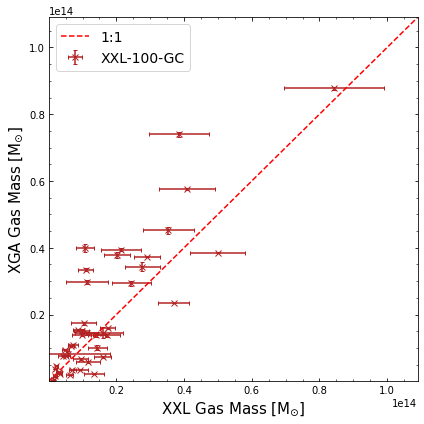

In [21]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ax.minorticks_on()
ax.tick_params(which='both', top=True, right=True, direction='in')
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_dblbeta_svikh_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_dblbeta_svikh_13_gm[:, 1:].T.value, fmt='x', 
             color=xxlgc100_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
# plt.savefig("non_paper_figures/xxl_dblbeta_svikh_1.3r500_gm_comp.pdf")
plt.show()
plt.close('all')